In [19]:
from skimage.transform import radon, iradon
import numpy as np
from skimage.draw import ellipse
import matplotlib.pyplot as plt
import phantominator as phm
from scipy.io import loadmat
from image_utils import discrete_imshow, make_ellipse, make_rectangle, make_ellipse_thickness, smooth_zero_center
from pathlib import Path

import matlab
import matlab.engine

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
COURSE_PATH = Path.cwd().resolve().parent
COURSE_PATH

WindowsPath('C:/Users/jeppe/Documents/MEGA/Base/DTU/02946 Scientific Computing for X-Ray Computed Tomography')

In [21]:
# Set up MATLAB engine
eng = matlab.engine.start_matlab()


In [22]:
eng.addpath(str((COURSE_PATH / "FA18").resolve()), nargout=0)
eng.addpath(str((COURSE_PATH / "AIRToolsII").resolve()), nargout=0)

In [23]:
eng.AIRToolsII_setup(nargout=0)

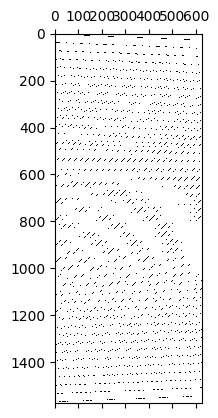

In [24]:
import matlab

N = 25
theta = np.linspace(0, 180, 45, endpoint=False)

# Convert numpy array to MATLAB double array
theta_matlab = matlab.double(theta.tolist())

A = eng.dense_paralleltomo(float(N), theta_matlab)

plt.spy(A)

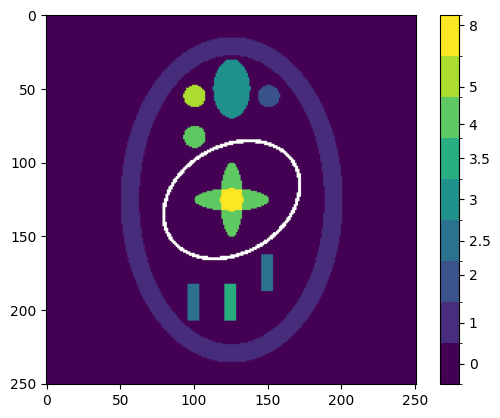

<Figure size 640x480 with 0 Axes>

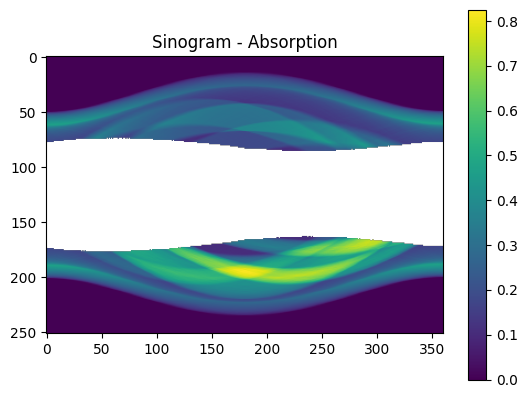

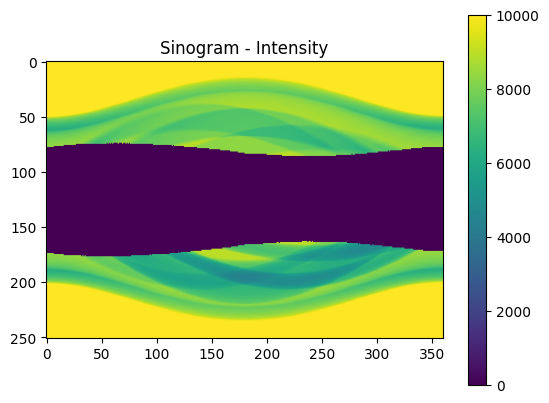

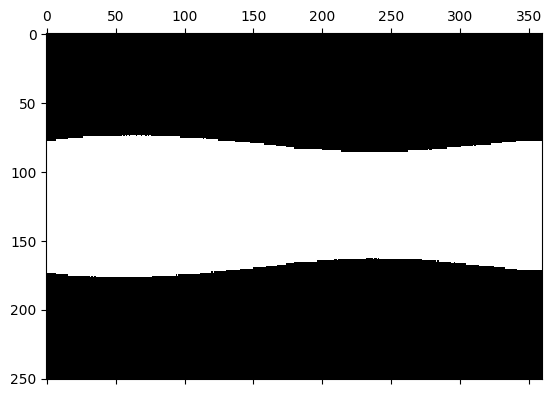

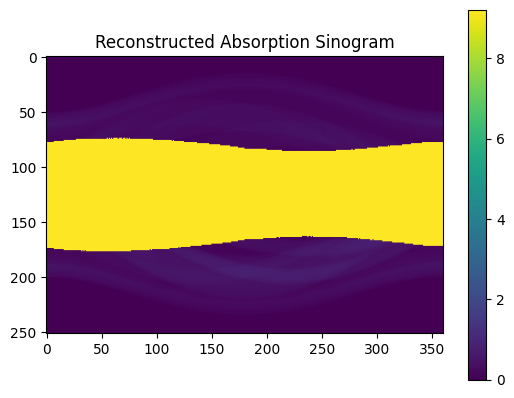

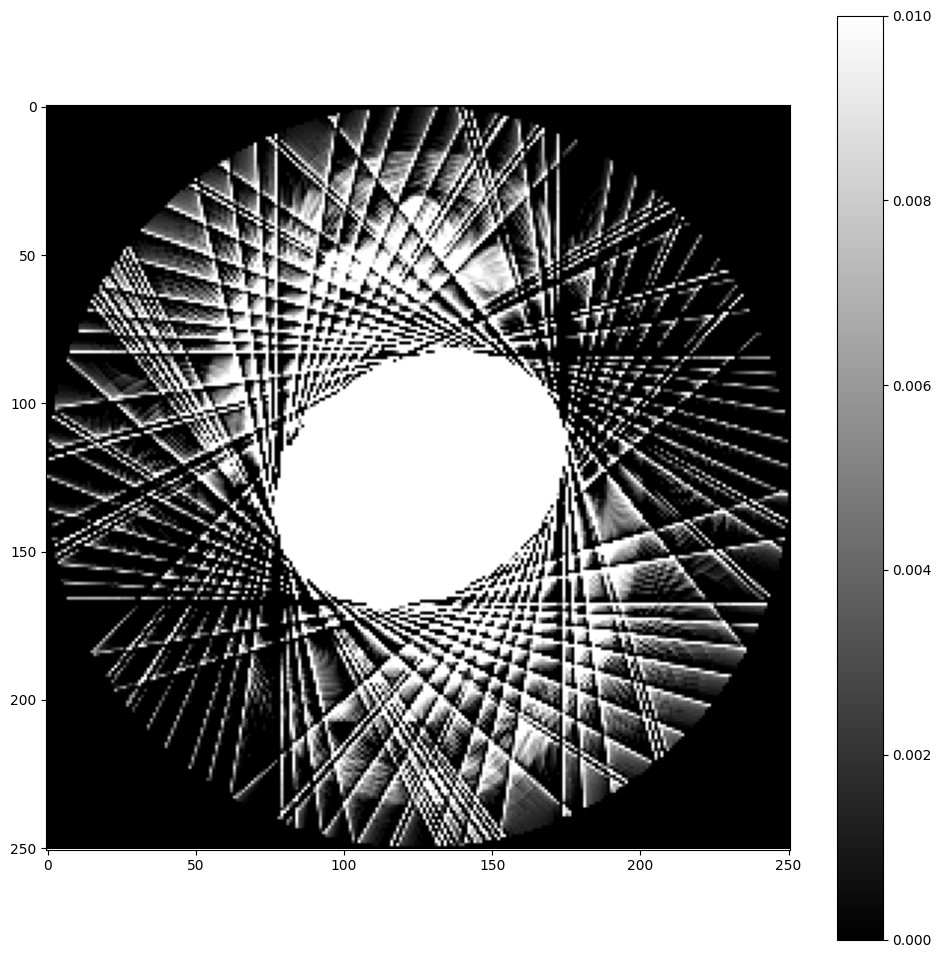

In [25]:
# Try to construct a phantom that would lead to exterior problem
N = 251
X = make_ellipse_thickness(intensity=1.0, thickness=0.05, axis_a=0.44, axis_b=0.3, center_x=0.5, center_y=0.5, shape=(N, N))

X += make_ellipse(intensity=3.0, axis_a=0.08, axis_b=0.05, center_x=0.5, center_y=0.2, shape=(N, N))
X += make_ellipse(intensity=5.0, axis_a=0.03, axis_b=0.03, center_x=0.40, center_y=0.22, shape=(N, N))
X += make_ellipse(intensity=2.0, axis_a=0.03, axis_b=0.03, center_x=0.60, center_y=0.22, shape=(N, N))
X += make_ellipse(intensity=4.0, axis_a=0.03, axis_b=0.03, center_x=0.40, center_y=0.33, shape=(N, N))

# Impenetrable center circle
INTENSITY_CENTER_SENTINEL = 100
DO_INTENSITY_CENTER_INF_CONVERSION = True
X += make_ellipse_thickness(thickness=0.01, intensity=INTENSITY_CENTER_SENTINEL, axis_a=0.15, axis_b=0.2, center_x=0.5, center_y=0.5, theta=30, shape=(N, N))

if DO_INTENSITY_CENTER_INF_CONVERSION:
    X[X==INTENSITY_CENTER_SENTINEL] = np.inf

# Bottom grill
X += make_rectangle(intensity=2.5, width=0.03, height=0.1, center_x=0.4, center_y=0.78, shape=(N, N))
X += make_rectangle(intensity=3.5, width=0.03, height=0.1, center_x=0.5, center_y=0.78, shape=(N, N))
X += make_rectangle(intensity=2.5, width=0.03, height=0.1, center_x=0.6, center_y=0.7, shape=(N, N))

# Center treasure
X += make_ellipse(intensity=4.0, axis_a=0.1, axis_b=0.03, center_x=0.5, center_y=0.5, shape=(N, N))
X += make_ellipse(intensity=4.0, axis_a=0.03, axis_b=0.1, center_x=0.5, center_y=0.5, shape=(N, N))

# plt.imshow(X, cmap="gray")
discrete_imshow(X)

theta = np.linspace(0, 180, 360, endpoint=False)

plt.figure()
A = radon(X, theta=theta) / N
I_0 = 1e4
I = I_0 * np.exp(-A)
I = np.nan_to_num(I, copy=False, nan=0.0)

plt.figure()
plt.imshow(A)
plt.title("Sinogram - Absorption")
plt.colorbar()

plt.figure()
plt.imshow(I)
plt.title("Sinogram - Intensity")
plt.colorbar()

plt.figure()
plt.spy(I)

# I_noisy = np.random.poisson(I)
# Avoid log(0) by using maximum of 1
# A_noisy = -np.log(np.maximum(I, 1) / I_0)

I_noisy = I + np.random.poisson(I)

A_recon = -np.log(np.maximum(I, 1)) + np.log(I_0)
# A_recon = -np.log(I / I_0)


plt.figure()
plt.imshow(A_recon)
plt.title("Reconstructed Absorption Sinogram")
plt.colorbar()

X_recon = iradon(A_recon, theta=theta, output_size=N,)
# discrete_imshow(X_recon)

X_recon[X_recon < 0] = 0.0  # Clip negative values for better visualization

plt.figure(figsize=(12, 12))
plt.imshow(X_recon, cmap="gray", vmax=0.01)
plt.colorbar()


C:\Users\jeppe\AppData\Local\Temp\ipykernel_52860\2662513686.py:43: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_recon), cmap="gray", vmax=None)


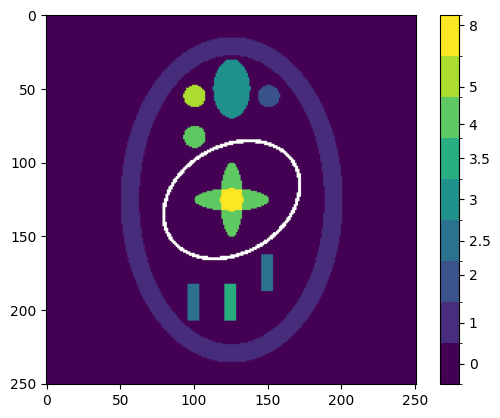

<Figure size 640x480 with 0 Axes>

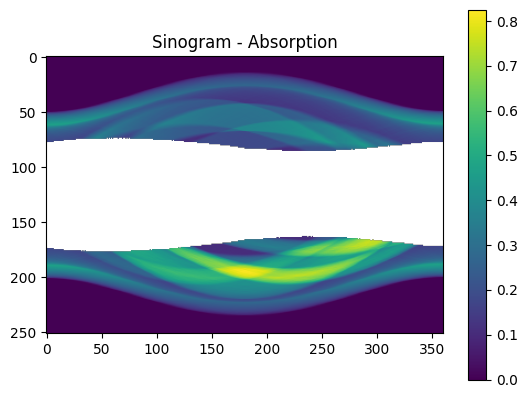

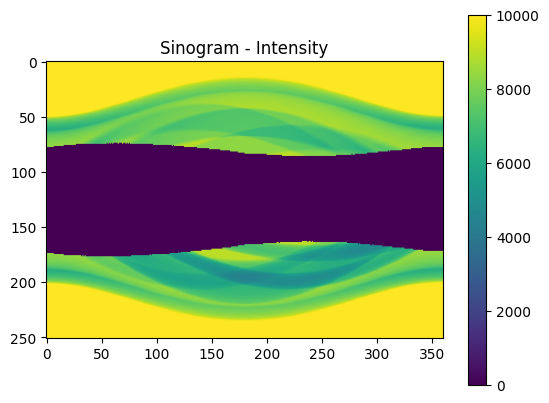

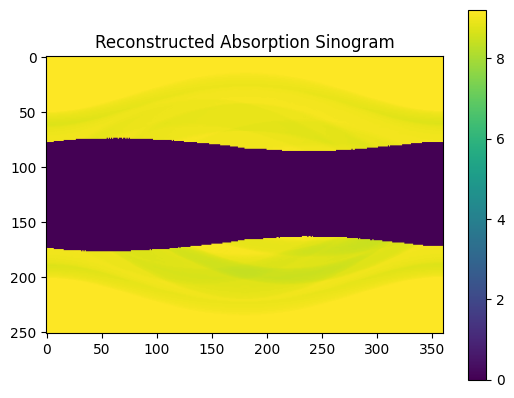

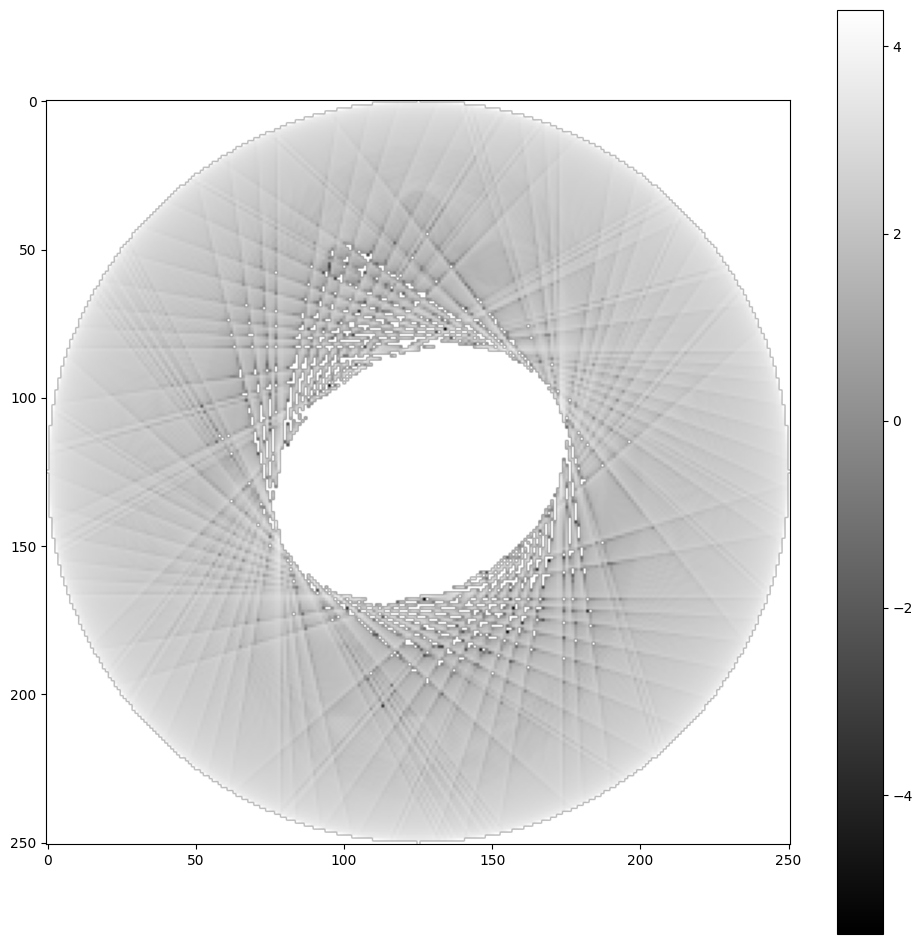

In [26]:

# plt.imshow(X, cmap="gray")
discrete_imshow(X)

# theta = np.arange(0,180,5)#np.linspace(0, 180, 360, endpoint=False)
theta = np.linspace(0, 180, 360, endpoint=False)


plt.figure()
A = radon(X, theta=theta) / N
I_0 = 1e4
I = I_0 * np.exp(-A)
I = np.nan_to_num(I, copy=False, nan=0.0)

plt.figure()
plt.imshow(A)
plt.title("Sinogram - Absorption")
plt.colorbar()

plt.figure()
plt.imshow(I)
plt.title("Sinogram - Intensity")
plt.colorbar()

# I_noisy = np.random.poisson(I)
# Avoid log(0) by using maximum of 1
# A_noisy = -np.log(np.maximum(I, 1) / I_0)

A_recon = np.log(np.maximum(I, 1)) # + np.log(I_0)
# A_recon = -np.log(I / I_0)


plt.figure()
plt.imshow(A_recon)
plt.title("Reconstructed Absorption Sinogram")
plt.colorbar()

X_recon = iradon(A_recon, theta=theta, output_size=N,) * N
# discrete_imshow(X_recon)

X_recon[X_recon < 0] = 0.0  # Clip negative values for better visualization

plt.figure(figsize=(12, 12))
plt.imshow(np.log(X_recon), cmap="gray", vmax=None)
plt.colorbar()


C:\Users\jeppe\AppData\Local\Temp\ipykernel_52860\2040010229.py:26: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_recon), cmap="gray", vmax=3.0, vmin=0.5)


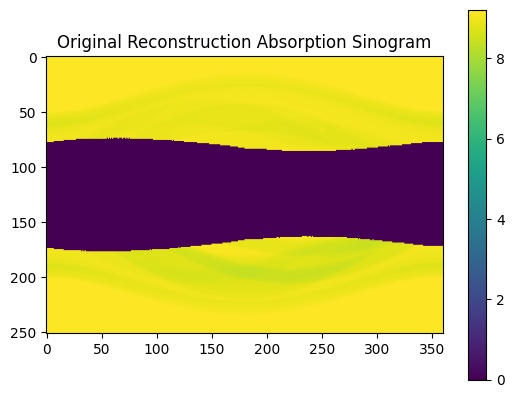

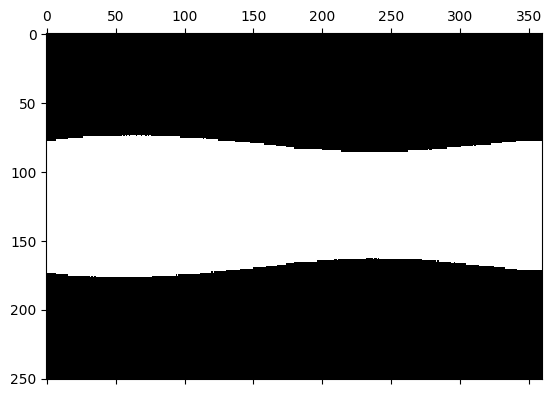

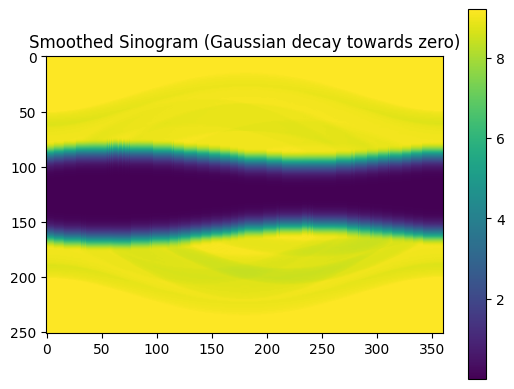

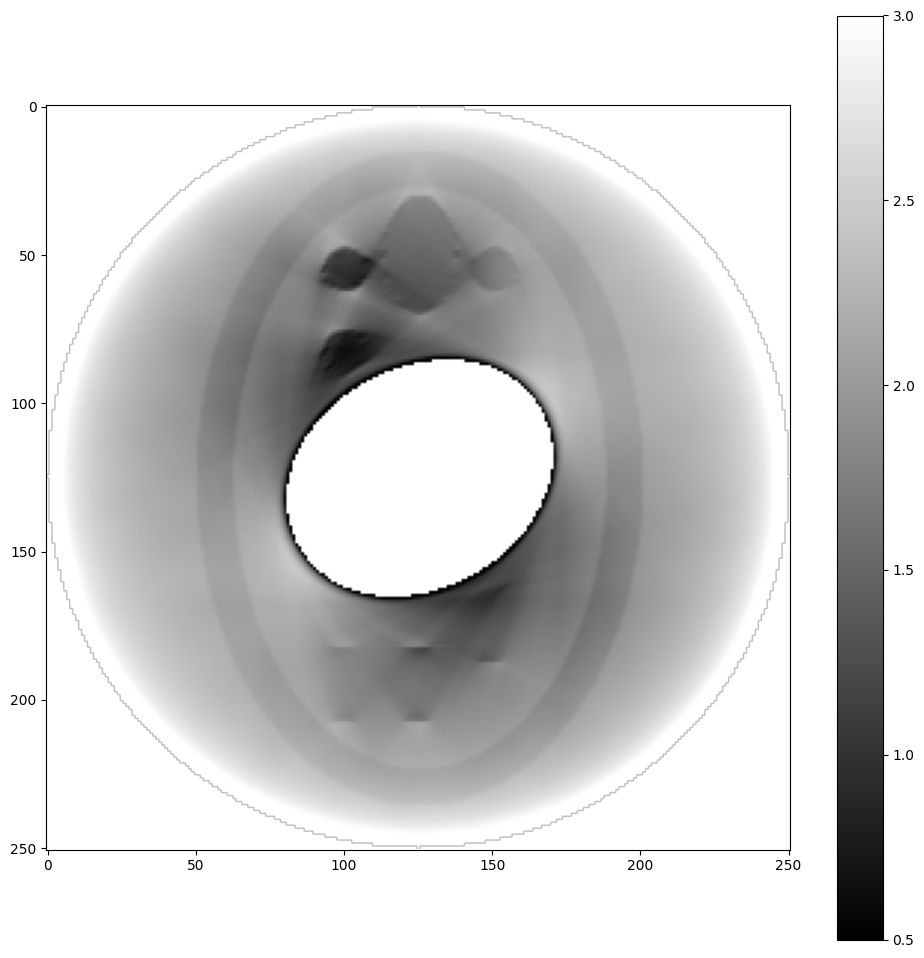

In [27]:
# Try trick to get smoothened sinogram
sinogram_original = A_recon

plt.figure()
plt.imshow(sinogram_original)
plt.colorbar()
plt.title("Original Reconstruction Absorption Sinogram")

plt.figure()
plt.spy(A_recon)


sinogram_smoothed = smooth_zero_center(sinogram_original, sigma=10.0)

plt.figure()
plt.imshow(sinogram_smoothed)
plt.colorbar()
plt.title("Smoothed Sinogram (Gaussian decay towards zero)")

X_recon = iradon(sinogram_smoothed, theta=theta, output_size=N,) * N
# discrete_imshow(X_recon)

X_recon[X_recon < 0] = 0.0  # Clip negative values for better visualization

plt.figure(figsize=(12, 12))
plt.imshow(np.log(X_recon), cmap="gray", vmax=3.0, vmin=0.5)
plt.colorbar()


In [29]:
# Try do SVD analysis


# Convert numpy array to MATLAB double array
theta_matlab = matlab.double(theta.tolist())

A = eng.dense_paralleltomo(float(N), theta_matlab)

plt.spy(A)


# A = paralleltomo(float(N), theta_matlab)
# U, S, VT =

MatlabExecutionError: 
  File C:\Users\jeppe\Documents\MEGA\Base\DTU\02946 Scientific Computing for X-Ray Computed Tomography\projects\dense_paralleltomo.m, line 2, in dense_paralleltomo
Requested 127800x63001 (60.0GB) array exceeds maximum array size preference (31.5GB) and might cause MATLAB to become unresponsive.


In [37]:
raise StopIteration

StopIteration: 

## 2.1

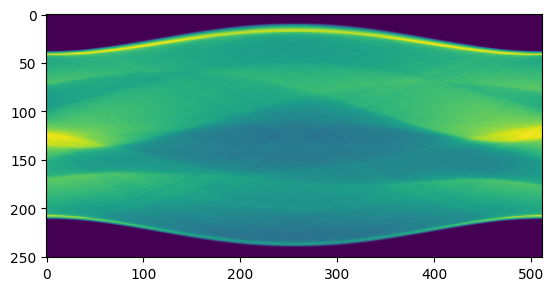

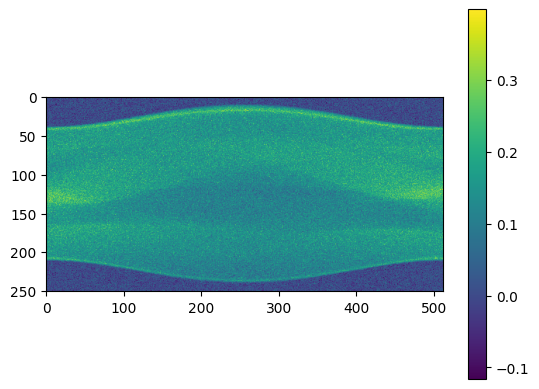

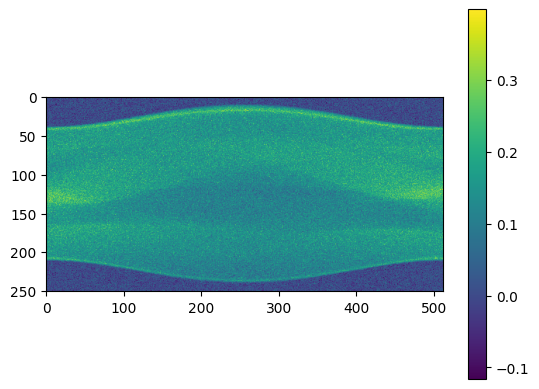

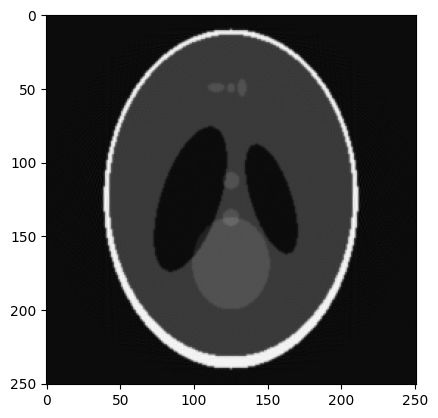

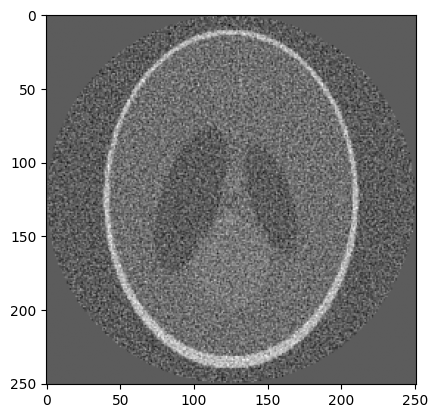

In [ ]:
N = 251


def make_ellipse(
    intensity: float = 1.0,
    axis_a: float = 0.5,
    axis_b: float = 0.5,
    center_x: float = 0.5,
    center_y: float = 0.5,
    theta: float = 0.0,  # in degrees
    shape: tuple = (N, N),
):
    # Convert theta from degrees to radians for skimage.draw.ellipse
    rr, cc = ellipse(center_x * N, center_y * N, axis_a * N, axis_b * N, shape=shape, rotation=np.radians(theta))
    img = np.zeros(shape, dtype=np.float32)
    img[rr, cc] = intensity
    return img


# X = make_ellipse(1.0, 0.2, 0.3, 0.5, 0.5, 45, (N, N))
X = phm.ct_shepp_logan(N=N)

I_0 = 1e3
theta = np.linspace(0, 180, 512, endpoint=False)
A = radon(X, theta=theta) / N
I = I_0 * np.exp(-A)
I_noisy = np.random.poisson(I)
# Avoid log(0) by using maximum of 1
A_noisy = -np.log(np.maximum(I_noisy, 1) / I_0)
# A_noisy = -np.log(I_noisy / I_0)

plt.figure()
plt.imshow(A)

plt.figure()
plt.imshow(A_noisy)
plt.colorbar()

plt.figure()
plt.imshow(A_noisy)
plt.colorbar()

iradon_args = {
    "theta": theta,
    "output_size": N,
    "filter_name": "ramp",
}
X_recon = iradon(A, **iradon_args)
X_noisy_recon = iradon(A_noisy, **iradon_args)

plt.figure()
plt.imshow(X_recon, cmap="gray")
plt.figure()
plt.imshow(X_noisy_recon, cmap="gray")

## 2.2

In [ ]:
# LLM:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
from skimage.transform import iradon

def iradon_scaled(sinogram, theta=None, filter_name='ramp', frequency_scaling=1.0, output_size=None):
    """
    Replicates MATLAB's iradon with frequencyScaling parameter.
    """
    # 1. Setup dimensions
    rows, cols = sinogram.shape
    n_padded = max(64, int(2 ** np.ceil(np.log2(2 * rows))))

    # 2. Generate the frequency axis (0 to 1, normalized)
    f = fftfreq(n_padded).reshape(-1, 1)  # Column vector
    f_abs = np.abs(f)

    # 3. Create the standard filter (e.g., Ramp is just |f|)
    # Note: skimage implementation details differ slightly, but this is the general math
    if filter_name == 'ramp':
        filt = f_abs
    elif filter_name == 'shepp-logan':
        filt = f_abs * np.sinc(f_abs)
    elif filter_name == 'cosine':
        filt = f_abs * np.cos(np.pi * f_abs / 2)
    elif filter_name == 'hamming':
        filt = f_abs * (0.54 + 0.46 * np.cos(np.pi * f_abs))
    elif filter_name == 'hann':
        filt = f_abs * (0.5 + 0.5 * np.cos(np.pi * f_abs))
    elif filter_name is None:
        filt = np.ones_like(f_abs)
    else:
        raise ValueError(f"Unknown filter: {filter_name}")

    # 4. Apply Frequency Scaling
    # MATLAB logic: compress filter to [0, scaling], zero out above scaling
    if frequency_scaling < 1.0:
        # Scale the frequency axis for the filter calculation
        # We want H_scaled(f) = H(f / scaling) for f < scaling
        # But since we computed 'filt' based on 'f', we can just re-map the array

        # Define mask for valid frequencies
        valid_mask = f_abs <= frequency_scaling

        # To compress the filter: evaluate the filter function at (f / scaling)
        # For simple 'ramp' (|f|), this means multiplying by (1/scaling) * value?
        # Actually, MATLAB's description: "filter is compressed to fit into [0, frequencyScaling]"
        # This implies we evaluate the filter shape on a stretched axis.

        # A simplified approximation for standard window filters (like Hamming/Hann)
        # is often just to zero out high frequencies (low-pass) if the shape is complex,
        # but strictly speaking, we should re-compute the window.

        # Re-evaluating Ramp with scaling:
        # The ramp part |f| stays |f|, but the window part changes.

        # Let's implement the cutoff (simplest interpretation of noise reduction):
        filt[~valid_mask] = 0

    # 5. Apply Filter in Fourier Domain
    projection_fft = fft(sinogram, n=n_padded, axis=0)
    filtered_projection_fft = projection_fft * filt
    filtered_sinogram = np.real(ifft(filtered_projection_fft, axis=0))[:rows, :]

    # 6. Backprojection (filter_name=None because we just filtered it)
    image = iradon(filtered_sinogram, theta=theta, filter_name=None, output_size=output_size)

    return image

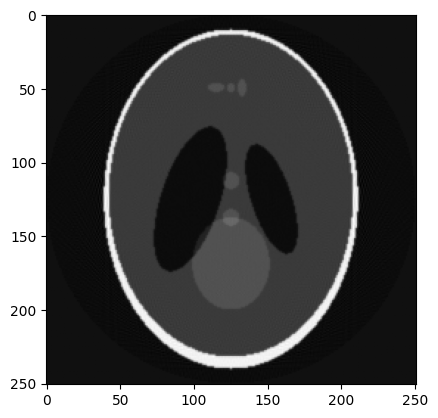

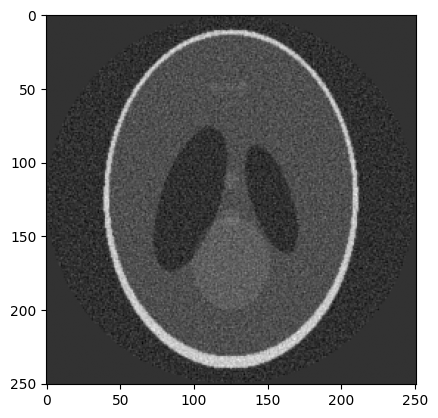

In [ ]:
iradon_args = {
    "theta": theta,
    "output_size": N,
    "filter_name": "ramp",
    "frequency_scaling": 0.5,
}
X_recon = iradon_scaled(A, **iradon_args)
X_noisy_recon = iradon_scaled(A_noisy, **iradon_args)

plt.figure()
plt.imshow(X_recon, cmap="gray")
plt.figure()
plt.imshow(X_noisy_recon, cmap="gray")

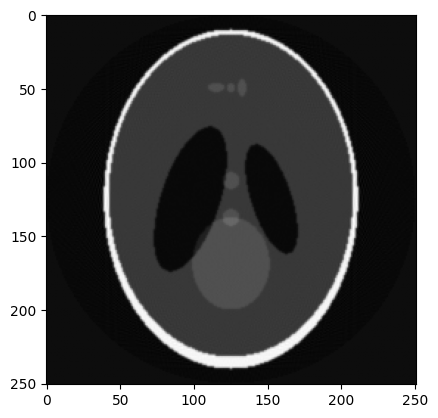

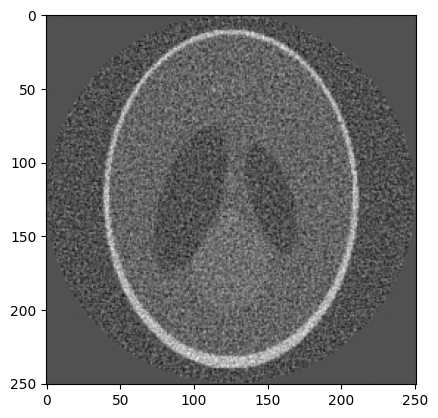

In [ ]:
I_0 = 1e3
theta = np.linspace(0, 180, 512, endpoint=False)
A = radon(X, theta=theta) / N
I = I_0 * np.exp(-A)
I_noisy = np.random.poisson(I)
# Avoid log(0) by using maximum of 1
A_noisy = -np.log(np.maximum(I_noisy, 1) / I_0)
# A_noisy = -np.log(I_noisy / I_0)


iradon_args = {
    "theta": theta,
    "output_size": N,
    "filter_name": "shepp-logan",
    "frequency_scaling": 0.6,
}
X_recon = iradon_scaled(A, **iradon_args)
X_noisy_recon = iradon_scaled(A_noisy, **iradon_args)

plt.figure()
plt.imshow(X_recon, cmap="gray")
plt.figure()
plt.imshow(X_noisy_recon, cmap="gray")

Output does not change too much qualitatively when using differente frequency scalings.



## 2.3 

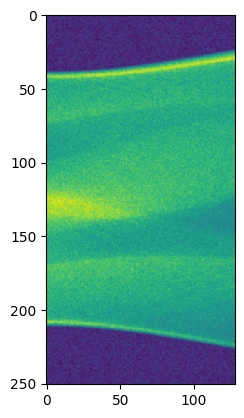

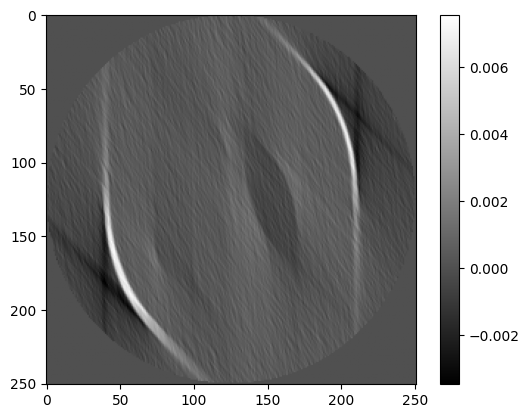

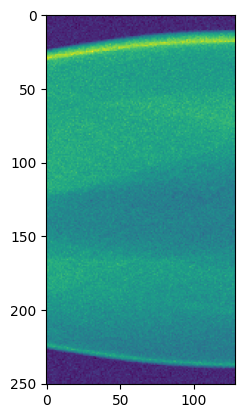

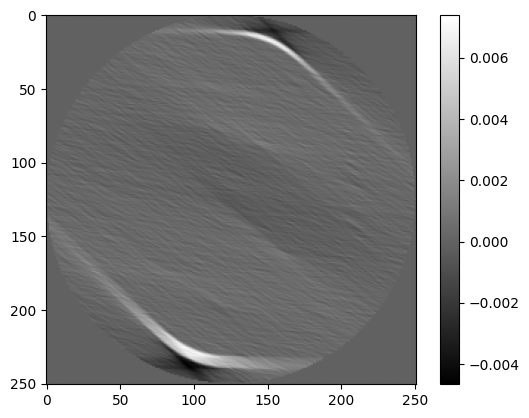

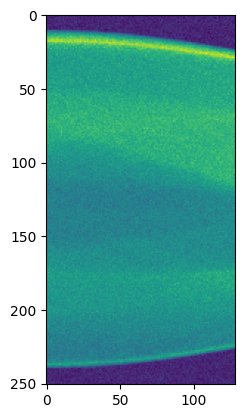

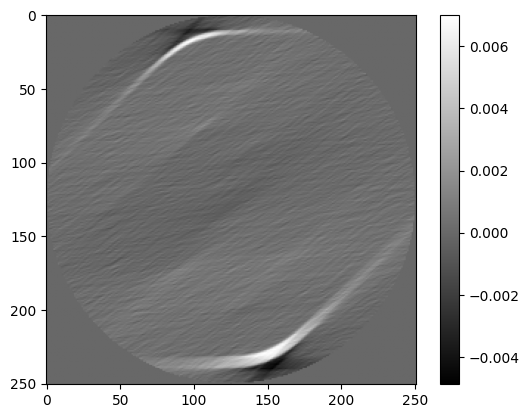

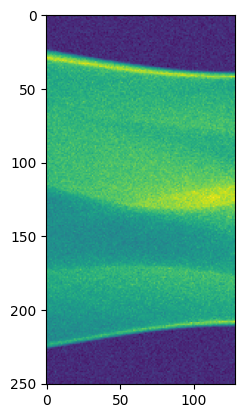

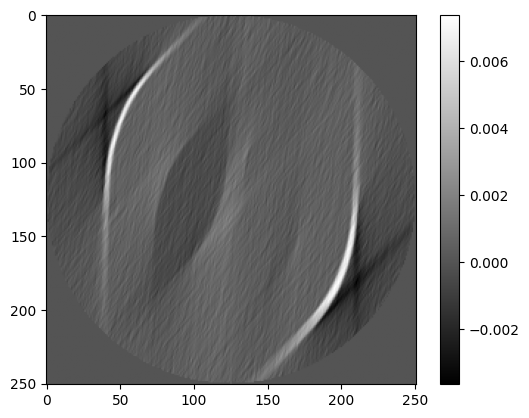

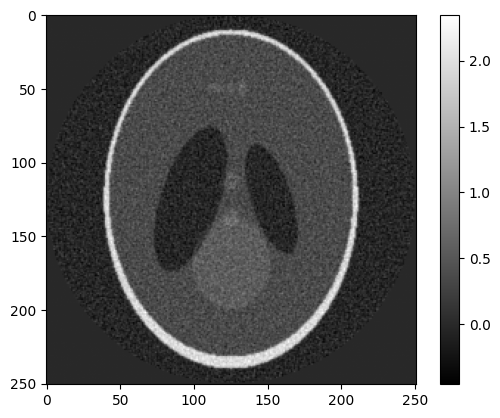

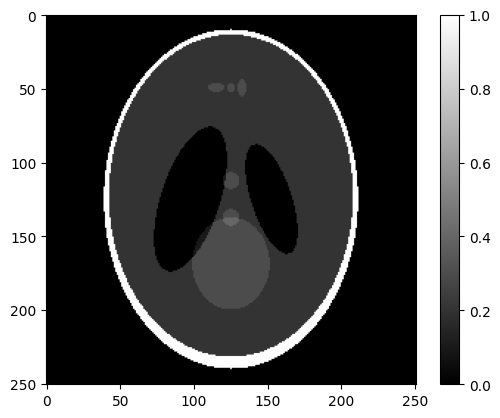

In [ ]:
I_0 = 1e4
M = 512
theta = np.linspace(0, 180, M, endpoint=False)
A = radon(X, theta=theta) / N
I = I_0 * np.exp(-A)
I_noisy = np.random.poisson(I)
# Avoid log(0) by using maximum of 1
A_noisy = -np.log(np.maximum(I_noisy, 1) / I_0)
# A_noisy = -np.log(I_noisy / I_0)

slices = [
    slice(i*M//4, (i+1)*M//4) for i in range(0, 4)
]

partial_reconstructions = []
for slice_ in slices:
    plt.figure()
    plt.imshow(A_noisy[:, slice_])

    # Reconstruct
    iradon_args = {
        "theta": theta[slice_],
        "output_size": N,
        "filter_name": "shepp-logan",
        "frequency_scaling": 0.6,
    }
    X_noisy_recon = iradon_scaled(A_noisy[:, slice_], **iradon_args)
    plt.figure()
    plt.imshow(X_noisy_recon, cmap="gray")
    plt.colorbar()

    partial_reconstructions.append(X_noisy_recon)

reconstruction = np.sum(partial_reconstructions, axis=0) * N
plt.figure()
plt.imshow(reconstruction, cmap="gray")
plt.colorbar()

plt.figure()
plt.imshow(X, cmap="gray")
plt.colorbar()

Note: Scaling is a bit odd here, likely from FFT or iradon assumptions

## 2.4

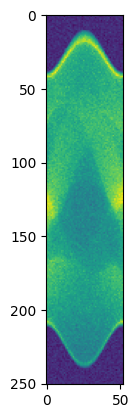

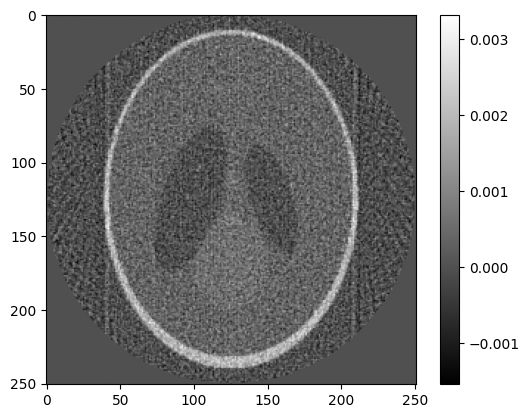

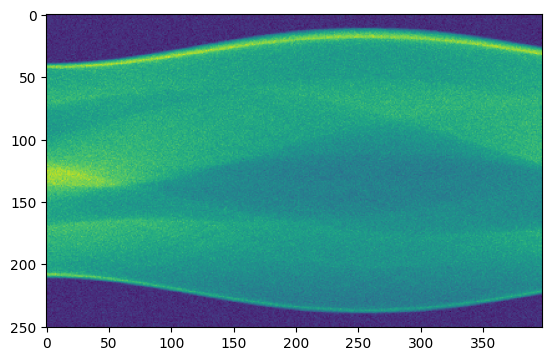

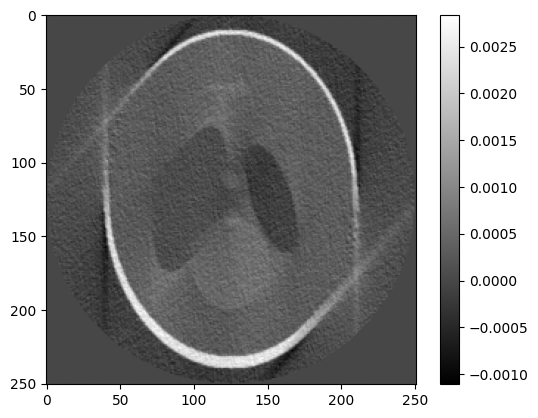

In [ ]:
I_0 = 1e4
M = 512
theta = np.linspace(0, 180, M, endpoint=False)
A = radon(X, theta=theta) / N
I = I_0 * np.exp(-A)
I_noisy = np.random.poisson(I)
# Avoid log(0) by using maximum of 1
A_noisy = -np.log(np.maximum(I_noisy, 1) / I_0)
# A_noisy = -np.log(I_noisy / I_0)

slice_few_view = slice(None, None, 10)
slice_limited_angle = slice(0, M * 140 // 180)

slices = [slice_few_view, slice_limited_angle]

partial_reconstructions = []
for slice_ in slices:
    plt.figure()
    plt.imshow(A_noisy[:, slice_])

    # Reconstruct
    iradon_args = {
        "theta": theta[slice_],
        "output_size": N,
        "filter_name": "shepp-logan",
        "frequency_scaling": 0.6,
    }
    X_noisy_recon = iradon_scaled(A_noisy[:, slice_], **iradon_args)
    plt.figure()
    plt.imshow(X_noisy_recon, cmap="gray")
    plt.colorbar()

    partial_reconstructions.append(X_noisy_recon)

# reconstruction = np.sum(partial_reconstructions, axis=0) * N
# plt.figure()
# plt.imshow(reconstruction, cmap="gray")
# plt.colorbar()


- Few-view: Just reduced resolution, but no spatial features are most 'lost' than others
- Limited-angle: Some angle range around which the phantom is ill-resolved

## 2.5

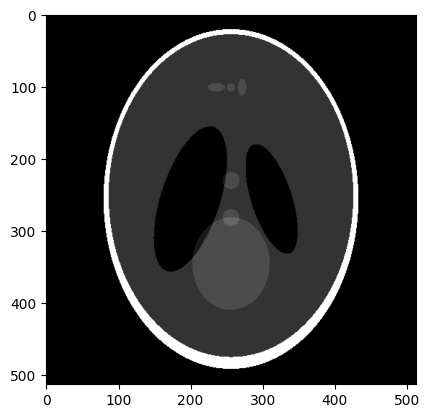

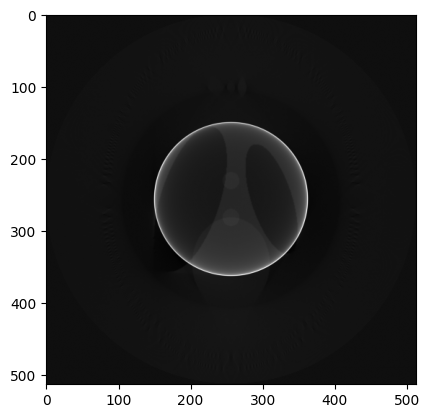

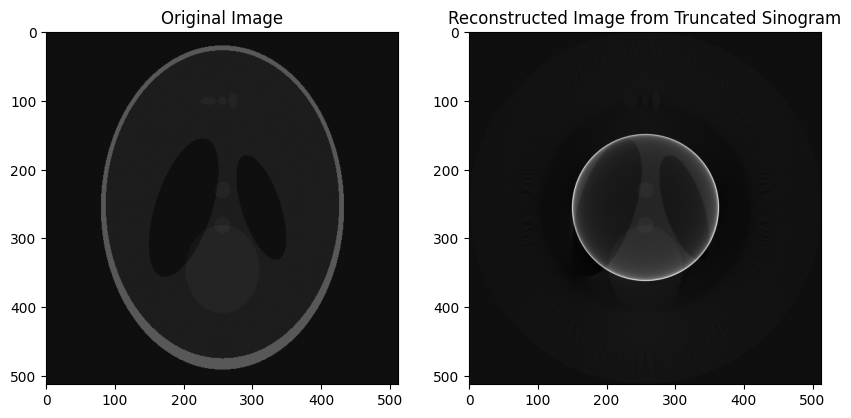

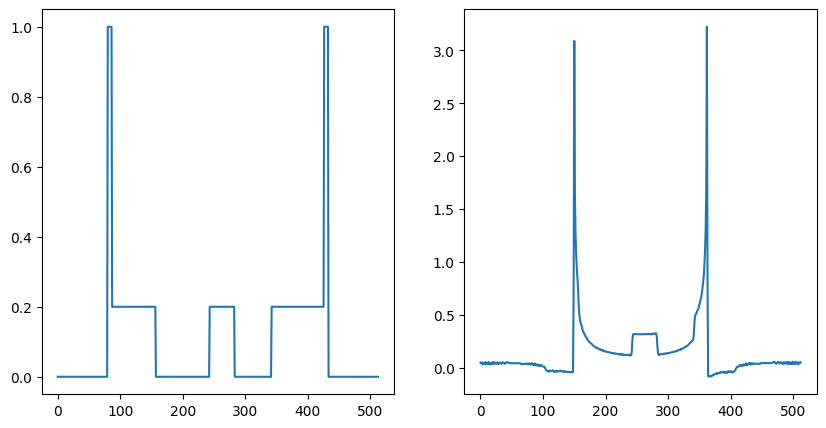

In [ ]:
N = 513
M = 1024
X = phm.ct_shepp_logan(N=N)
theta = np.linspace(0, 180, M, endpoint=False)

A = radon(X, theta=theta) / N
A_trunc = A[150:-150]
X_recon = iradon(A_trunc, theta=theta, output_size=N, filter_name="shepp-logan") * N

plt.figure()
plt.imshow(X, cmap="gray")
plt.figure()
plt.imshow(X_recon, cmap="gray")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
vmin = min(X.min(), X_recon.min())
vmax = max(X.max(), X_recon.max())
axs[0].imshow(X, cmap="gray", vmin=vmin, vmax=vmax)
axs[0].set_title("Original Image")
axs[1].imshow(X_recon, cmap="gray", vmin=vmin, vmax=vmax)
axs[1].set_title("Reconstructed Image from Truncated Sinogram")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(X[N//2, :], label="Original")
axs[1].plot(X_recon[N//2, :], label="Reconstructed")


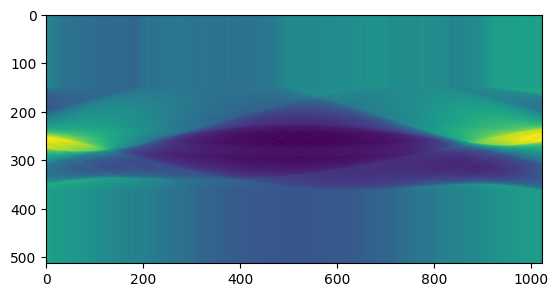

In [ ]:
plt.imshow(A_trunc)

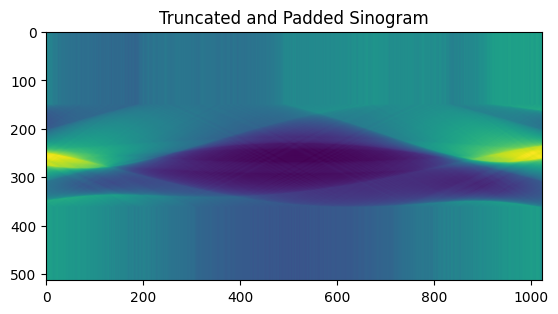

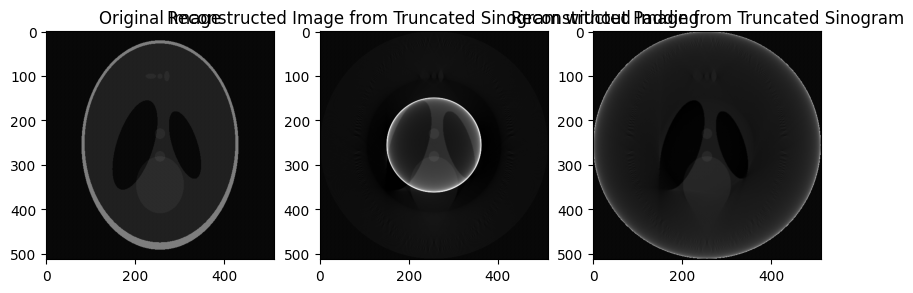

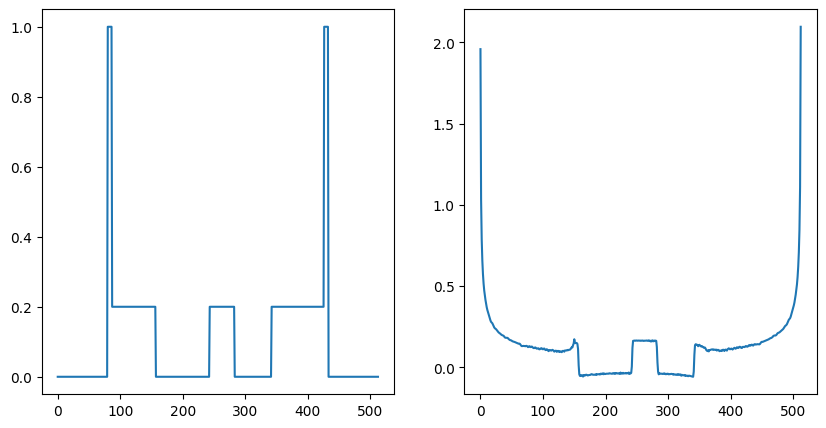

In [ ]:
# Trick: Padding
N = 513
M = 1024
X = phm.ct_shepp_logan(N=N)
theta = np.linspace(0, 180, M, endpoint=False)

N_crop = 150
N_prepad = 150
A = radon(X, theta=theta) / N
A_trunc = A[N_crop:-N_crop]
A_trunc = np.pad(A_trunc, ((N_prepad, 0), (0, 0)), mode="edge")
A_trunc = np.pad(A_trunc, ((0, N_prepad), (0, 0)), mode="edge")
X_recon = iradon(A_trunc, theta=theta, output_size=N, filter_name="shepp-logan") * N

plt.figure()
plt.imshow(A_trunc)
plt.title("Truncated and Padded Sinogram")

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
vmin = min(X.min(), X_recon.min())
vmax = max(X.max(), X_recon.max())
axs[0].imshow(X, cmap="gray", vmin=vmin, vmax=vmax)
axs[0].set_title("Original Image")
X_trunc = iradon(A[N_crop:-N_crop], theta=theta, output_size=N, filter_name="shepp-logan") * N
axs[1].imshow(X_trunc, cmap="gray", vmin=vmin, vmax=vmax)
axs[1].set_title("Reconstructed Image from Truncated Sinogram without Padding")

axs[2].imshow(X_recon, cmap="gray", vmin=vmin, vmax=vmax)
axs[2].set_title("Reconstructed Image from Truncated Sinogram")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(X[N//2, :], label="Original")
axs[1].plot(X_recon[N//2, :], label="Reconstructed")


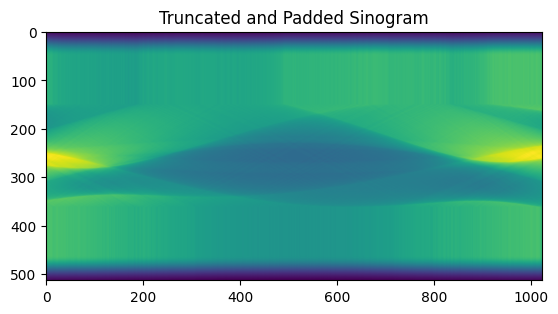

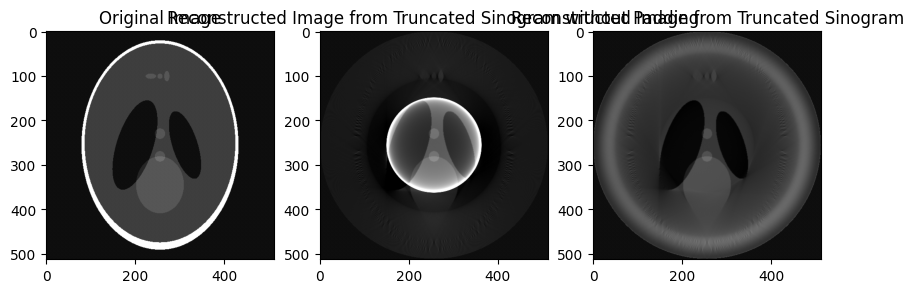

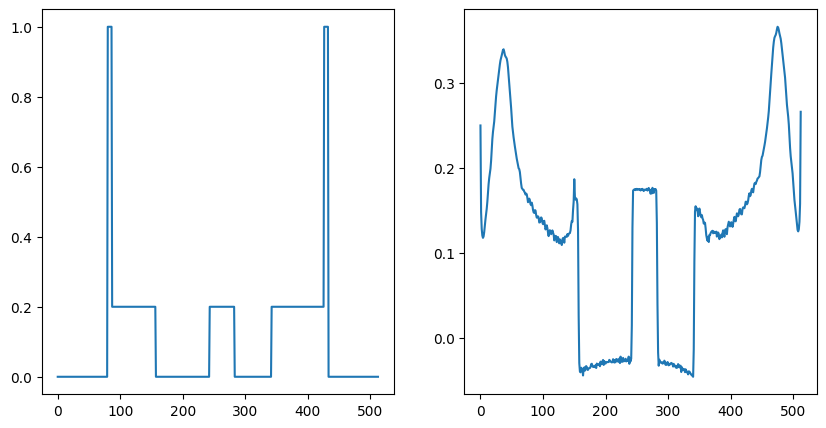

In [ ]:
# Trick: Padding
N = 513
M = 1024
X = phm.ct_shepp_logan(N=N)
theta = np.linspace(0, 180, M, endpoint=False)

def pad_with_gaussian(vector, pad_width, iaxis, kwargs):
    """
    Custom padding function for np.pad that applies Gaussian decay.
    Expects 'sigma' in kwargs to control the decay rate.
    """
    pad_before, pad_after = pad_width
    sigma = kwargs.get('sigma', 10)  # Default sigma if not provided

    # 1. Pad the beginning (Left/Top)
    if pad_before > 0:
        # Create a distance array: [pad_before, ..., 2, 1]
        x = np.arange(pad_before, 0, -1)
        # Get the edge value from the original data
        edge_val = vector[pad_before]
        # Apply Gaussian formula: A * exp(-x^2 / 2*sigma^2)
        vector[:pad_before] = edge_val * np.exp(-(x**2) / (2 * sigma**2))

    # 2. Pad the end (Right/Bottom)
    if pad_after > 0:
        # Create a distance array: [1, 2, ..., pad_after]
        x = np.arange(1, pad_after + 1)
        # Get the edge value from the original data
        # Note: -pad_after is the start of the pad, so -pad_after-1 is the last data point
        edge_val = vector[-pad_after - 1]
        vector[-pad_after:] = edge_val * np.exp(-(x**2) / (2 * sigma**2))

N_crop = 150
N_prepad = 100
N_pad = 50
A = radon(X, theta=theta) / N
A_trunc = A[N_crop:-N_crop]
A_trunc = np.pad(A_trunc, ((N_prepad, 0), (0, 0)), mode="edge")
A_trunc = np.pad(A_trunc, ((0, N_prepad), (0, 0)), mode="edge")
A_trunc = np.pad(A_trunc, ((N_pad, 0), (0, 0)), mode=pad_with_gaussian, sigma=25)
A_trunc = np.pad(A_trunc, ((0, N_pad), (0, 0)), mode=pad_with_gaussian, sigma=25)
X_recon = iradon(A_trunc, theta=theta, output_size=N, filter_name="shepp-logan") * N

plt.figure()
plt.imshow(A_trunc)
plt.title("Truncated and Padded Sinogram")

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
vmin = min(X.min(), X_recon.min())
vmax = max(X.max(), X_recon.max())
axs[0].imshow(X, cmap="gray", vmin=vmin, vmax=vmax)
axs[0].set_title("Original Image")
X_trunc = iradon(A[N_crop:-N_crop], theta=theta, output_size=N, filter_name="shepp-logan") * N
axs[1].imshow(X_trunc, cmap="gray", vmin=vmin, vmax=vmax)
axs[1].set_title("Reconstructed Image from Truncated Sinogram without Padding")

axs[2].imshow(X_recon, cmap="gray", vmin=vmin, vmax=vmax)
axs[2].set_title("Reconstructed Image from Truncated Sinogram")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(X[N//2, :], label="Original")
axs[1].plot(X_recon[N//2, :], label="Reconstructed")


c:\Users\jeppe\Documents\MEGA\Base\DTU\02946 Scientific Computing for X-Ray Computed Tomography\.venv\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


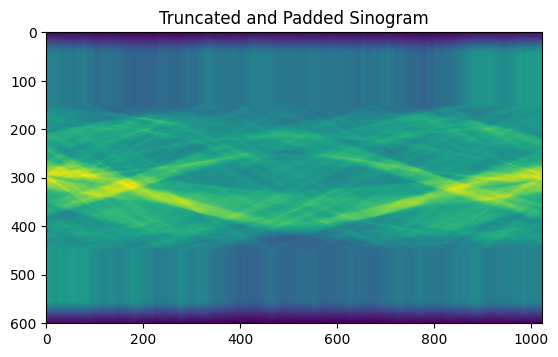

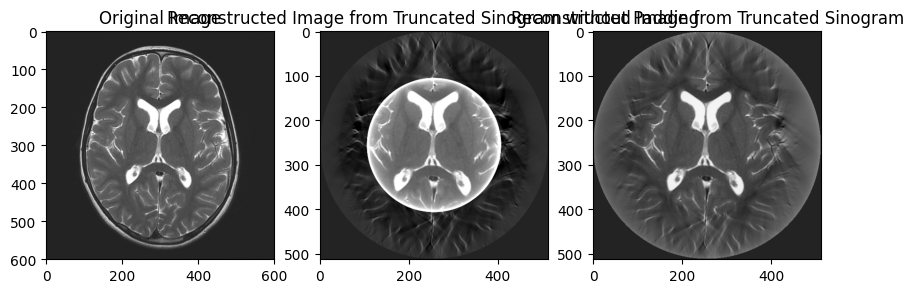

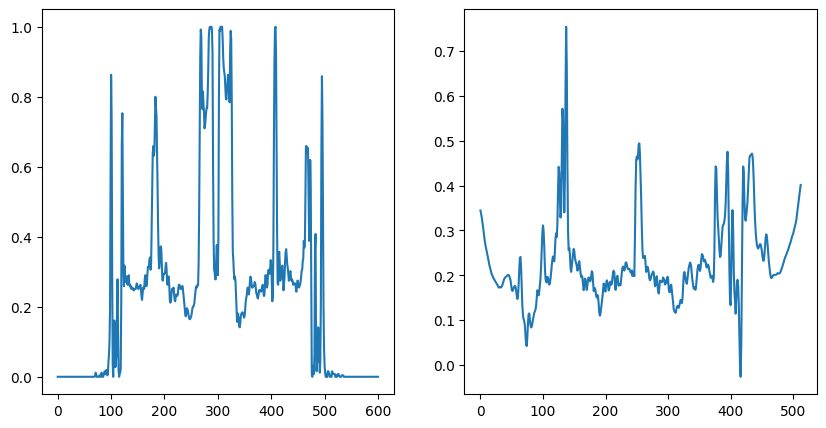

In [ ]:
# Import data
data_2_6 = loadmat("brain_radiopedia.mat")
X = data_2_6["X"]

N_crop = 150
N_prepad = 100
N_pad = 50
A = radon(X, theta=theta) / N
A_trunc = A[N_crop:-N_crop]
A_trunc = np.pad(A_trunc, ((N_prepad, 0), (0, 0)), mode="edge")
A_trunc = np.pad(A_trunc, ((0, N_prepad), (0, 0)), mode="edge")
A_trunc = np.pad(A_trunc, ((N_pad, 0), (0, 0)), mode=pad_with_gaussian, sigma=25)
A_trunc = np.pad(A_trunc, ((0, N_pad), (0, 0)), mode=pad_with_gaussian, sigma=25)
X_recon = iradon(A_trunc, theta=theta, output_size=N, filter_name="shepp-logan") * N

plt.figure()
plt.imshow(A_trunc)
plt.title("Truncated and Padded Sinogram")

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
vmin = min(X.min(), X_recon.min())
vmax = max(X.max(), X_recon.max())
axs[0].imshow(X, cmap="gray", vmin=vmin, vmax=vmax)
axs[0].set_title("Original Image")
X_trunc = iradon(A[N_crop:-N_crop], theta=theta, output_size=N, filter_name="shepp-logan") * N
axs[1].imshow(X_trunc, cmap="gray", vmin=vmin, vmax=vmax)
axs[1].set_title("Reconstructed Image from Truncated Sinogram without Padding")

axs[2].imshow(X_recon, cmap="gray", vmin=vmin, vmax=vmax)
axs[2].set_title("Reconstructed Image from Truncated Sinogram")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(X[N//2, :], label="Original")
axs[1].plot(X_recon[N//2, :], label="Reconstructed")
